# **Imports**

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install tbats --quiet
!pip install sktime --quiet
from tbats import TBATS
from sktime.performance_metrics.forecasting import *

# **Evaluation Mertics**

In [ ]:
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root = True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric = True)
    mse_ = mean_squared_error(y_true, y_pred)

    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_ ,'MSE': mse_}

    df = pd.DataFrame(dict_, index = [model_name])
    return df.round(decimals = 2)

# **Loading Dataset and Prepare**

In [ ]:
demand_train_df = pd.read_parquet('demand_train.parquet')
demand_test_df = pd.read_parquet('demand_test.parquet')


demand_train_df = demand_train_df[~demand_train_df['PULocationID'].isin([264, 265])]
demand_test_df = demand_test_df[~demand_test_df['PULocationID'].isin([264, 265])]

demand_train_df['timestamp'] = pd.to_datetime(demand_train_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
demand_test_df['timestamp'] = pd.to_datetime(demand_test_df['timestamp'], format='%Y-%m-%d %H:%M:%S')

demand_test_df.set_index('timestamp', inplace=True)
demand_train_df.set_index('timestamp', inplace=True)

demand_test_df=demand_test_df.sort_values('timestamp')
demand_train_df=demand_train_df.sort_values('timestamp')

In [ ]:

df = demand_train_df.groupby(['PULocationID'])
df_temp_train = df.get_group(50)

df = demand_test_df.groupby(['PULocationID'])
df_temp_test = df.get_group(50)


# **TBATS Model Training**

tbats(y, use.box.cox = NULL, use.trend = NULL, use.damped.trend = NULL,
  seasonal.periods = NULL, use.arma.errors = TRUE,
  use.parallel = length(y) > 1000, num.cores = 2, bc.lower = 0,
  bc.upper = 1, biasadj = FALSE, model = NULL, ...)


*   y : The time series to be forecast.
*   use.box.cox : TRUE/FALSE indicates whether to use the Box-Cox transformation or not. If NULL then both are tried and the best fit is selected by AIC.
*   use.trend : TRUE/FALSE indicates whether to include a trend or not. If NULL then both are tried and the best fit is selected by AIC.
*   use.damped.trend : TRUE/FALSE indicates whether to include a damping parameter in the trend or not. If NULL then both are tried and the best fit is selected by AIC.
*   seasonal.periods : If y is numeric then seasonal periods can be specified with this parameter.



daily - weekly

In [ ]:
model = TBATS(seasonal_periods=[24*6,24*6*7])
results = model.fit(df_temp_train['demand'])

forecast_values = results.forecast(steps=len(df_temp_test))


In [ ]:
print_metrics(df_temp_test['demand'].values , forecast_values, 'TBATS')

,MAE,RMSE,MAPE,SMAPE,MSE
TBATS,7.62,8.3,6.674609e+15,0.96,68.83


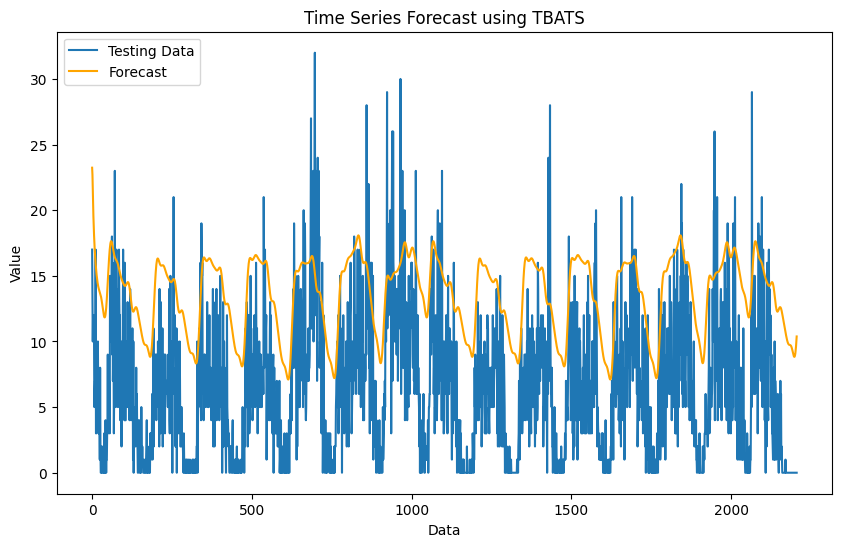

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df_temp_test['demand'].values, label='Testing Data')
plt.plot(forecast_values, label='Forecast', color='Orange')

plt.legend(loc='upper left')
plt.title('Time Series Forecast using TBATS')
plt.xlabel('Data')
plt.ylabel('Value')
plt.show()